In [1]:
import sys
sys.path.append('C:/Users/juans/OneDrive/Documentos/iaProyect/Cognitive')
print(sys.path)  # Esto mostrará todas las rutas en sys.path

from model.training import ModelTrainer 
from model.inferences import ModelMetrics
from model.utils.data_extraction import DataExtractor
import numpy as np


['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\python311.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv', '', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\Pythonwin', 'C:/Users/juans/OneDrive/Documentos/iaProyect/Cognitive']


In [2]:
trainer = ModelTrainer()
model = trainer.run()

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------


KeyboardInterrupt: 

In [3]:
nameFile = DataExtractor.save_model('../trained/', model, 'stacking_model.pkl')

NameError: name 'model' is not defined

['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\python311.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv', '', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\Pythonwin', 'C:/Users/juans/OneDrive/Documentos/iaProyect/Cognitive']
Classification Report:
           

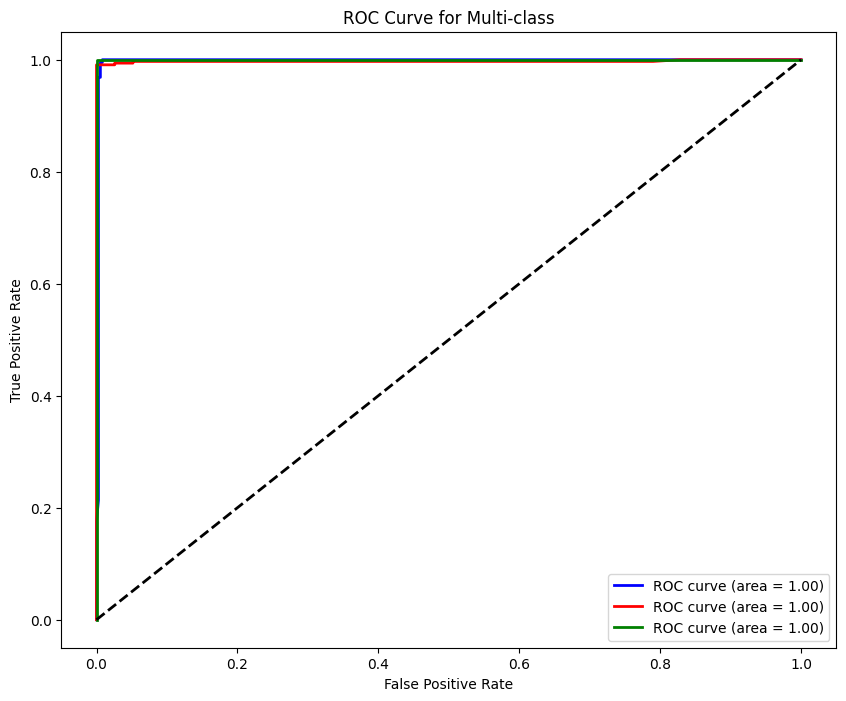

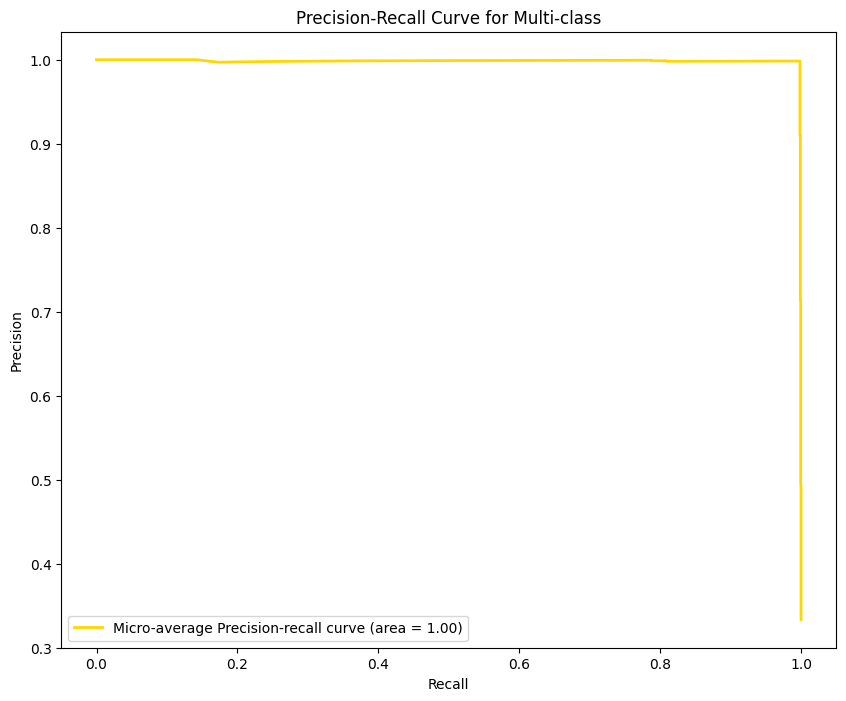

F1 Score: 1.00


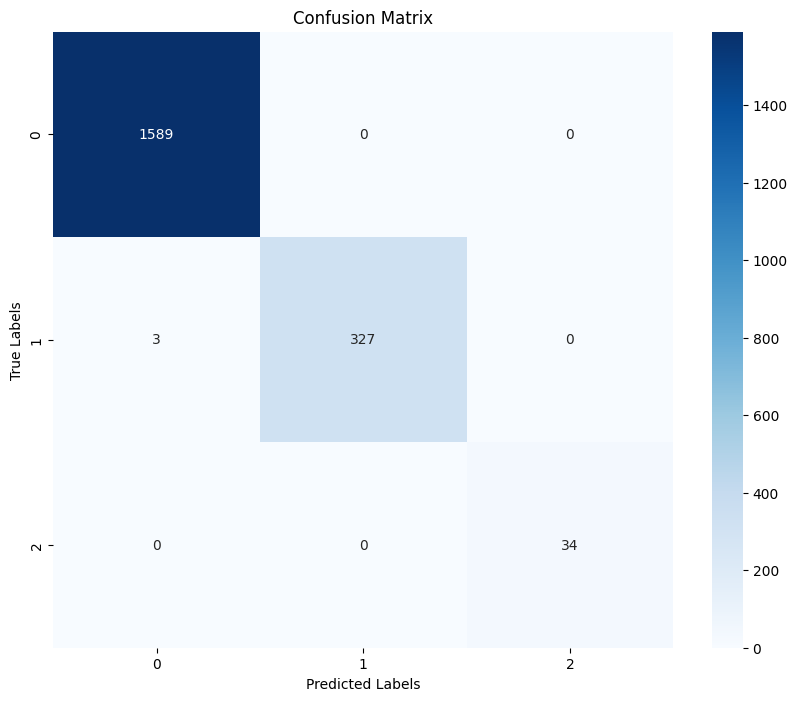

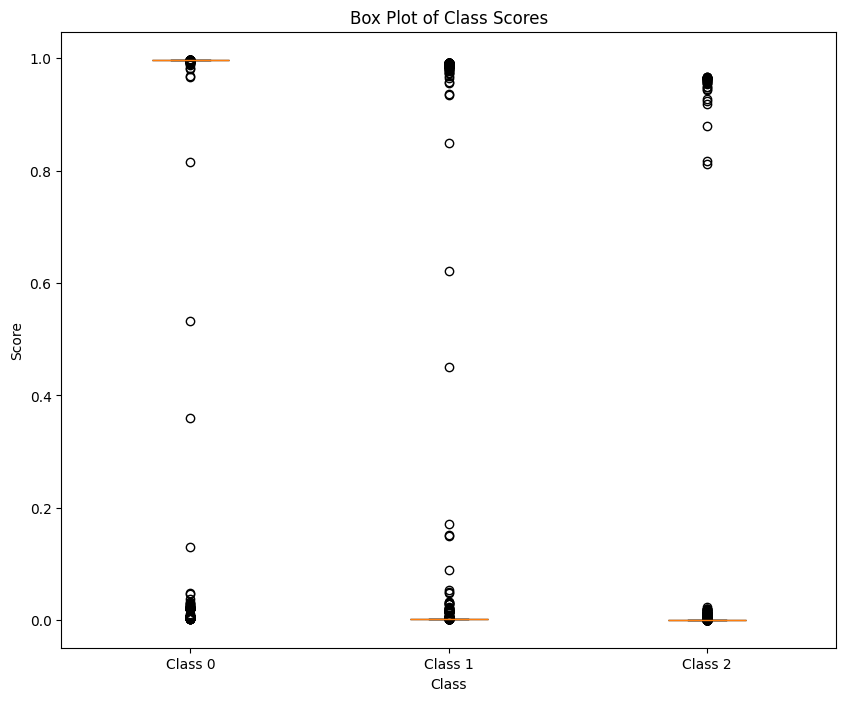

The model does not support feature importance.


In [1]:
import sys
sys.path.append('C:/Users/juans/OneDrive/Documentos/iaProyect/Cognitive')
print(sys.path)  # Esto mostrará todas las rutas en sys.path

from model.training import ModelTrainer 
from model.inferences import ModelMetrics
from model.utils.data_extraction import DataExtractor
import numpy as np


nameFile = 'stacking_model.pkl_2024-09-03_16-43-57.pkl'


#separate date valiudation
from sklearn.model_selection import train_test_split

# Supón que ya has cargado tus datos y entrenado tu modelo, entonces puedes hacer lo siguiente:
data = DataExtractor.load_data_pickle('../../data/','DB sin RM (filtrado) - normalizado 01.pkl')

test_data,aux_data = train_test_split(data, test_size=0.7, random_state=42)
new_X_test = aux_data.drop(columns=['Deterioro Cognitivo'])
new_y_test = aux_data['Deterioro Cognitivo']

n_classes = len(np.unique(new_y_test))

modeltrainer = DataExtractor.load_model('../trained', nameFile)
metrics = ModelMetrics(modeltrainer, new_X_test, new_y_test, n_classes)
metrics.print_classification_report()
metrics.plot_roc_curve()
metrics.plot_precision_recall_curve()
metrics.print_f1_score()
metrics.plot_confusion_matrix() 
